# 04 EDA Timeseries Dataset - a

In this Notebook, I will do an Exploratory Data Analysis with the timeseries dataset collected from the previous Notebook.

# The TimeSeries

The tiemseries dataset is a collection of close to 10K rows with ~50 features. The timeseries is organized by:
- Stratgey
- -- Funds in the strategy
- --- Monthy observation
- ---- Flows
- ---- Performances
- ---- Events
- ---- Internet Document Download KPIs
- ---- Macro research Scoring


# EDA Tasks
- loading the dataset
- descriptive statistics
- dealing with missing values
- create the target value [-1, 0, +1]

## Next Notebooks
### 04 EDA Timeseries Dataset - b

- identifying potential outliers
- vizualization
- rolling / resampling / differencing
- global analysis (all obervations)
- analysis with a dedicated strategy (which includes all funds)
-- seasonality
-- trends
-- using statsmodel

## Loading the data
I start by loading some librairies, initializing the log file and initializing some constant.
The time series was stroed in the file by the previous Notebooks.
Il load the data and display shape and sample row.

### Data Dictionary
I created a list of columns and completed the definition (business).

In [1]:
# log comment, warnings and errors in a specific files

from datetime import datetime
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

now = datetime.now()
filename = 'logs/04-EDA_timeseries-' + now.strftime("%m%d%Y%H%M%S") + '.log'

logging.basicConfig(filename=filename ,format='%(asctime)s | %(levelname)s: %(message)s', level=20)
logging.info('I start to run your Notebook ! -- Good Luck :-) It is:  '+ now.strftime("%m/%d/%Y, %H:%M:%S"))

# declare some constants
folder = '_anonymized/'

# set figure size
sns.set(rc={'figure.figsize':(15,4)})

In [2]:
# read the csv file into ts
ts = pd.read_csv(folder+'final_time_series.csv')
try:
    ts.drop('Unnamed: 0', axis=1, inplace=True)
except:
    logging.warning('No [Unnamed: 0] colum to delete.')
print(ts.shape)
logging.info('TIME SERIES shape'+ str(ts.shape[0])  )
ts.sample(8)

(9891, 49)


,SRC_UID,PRODUCT_STRATEGY,ASSET_NAME,FUND_NAME,STRATEGY_CAPABILITY,IS_STRATEGIC,EOM,ADMINSTRATION_FEES,MANAGEMENT_FEES,MULTI_MANAGER_STRUCTURE,...,FUND_SIZE,SUB_FUNDS_SHARE_PARTS,SUB_FUNDS_SHARE_SIZE_SF_CCY,DOWNLOADED_DOCUMENTS,WEIGHTED,COUNTRY,PSU,PSU_SCORE,POSITIVE_RFP,EVENT_IMPACT
8063,186759829869822,Tadorna tadorna,Plegadis ridgwayi,Haematopus ater,Thematic,Yes,2013-04-30,0.002241,0.010219,1,...,2.403037e+07,1.941849e+04,2.184579e+06,NaN,0.4642,U.S.A.,US,3.0,True,NaN
74,206670688,Cyrtodactylus louisiadensis,Dusicyon thous,Oreamnos americanus,Money Market,No,2016-03-31,0.000277,0.001631,1,...,2.537404e+09,3.778852e+06,5.074808e+08,NaN,NaN,NaN,NaN,NaN,NaN,13.076849
6555,656760542396,Lamprotornis nitens,Centrocercus urophasianus,Tauraco porphyrelophus,Thematic,Yes,2017-03-31,0.002287,0.012067,1,...,4.030598e+08,1.812197e+05,2.878999e+07,2880.0,0.4510,U.S.A.,US,4.0,True,12.625619
3859,36740368922,Ara chloroptera,Spermophilus armatus,Psophia viridis,Core Bonds,No,2012-01-31,0.000300,0.001280,0,...,3.499140e+08,7.852891e+04,6.998279e+07,209.0,NaN,NaN,NaN,NaN,NaN,NaN
6137,272675524722,Actophilornis africanus,Sarcorhamphus papa,Antidorcas marsupialis,Thematic,Yes,2015-08-31,0.002322,0.012739,1,...,5.000440e+08,5.437414e+05,4.167034e+07,15437.0,0.6020,U.S.A.,US,4.0,True,4.455308
695,206670711,Ara chloroptera,Alectura lathami,Alouatta seniculus,Core & Specialist Equities,No,2012-07-31,0.000300,0.008500,0,...,4.528397e+08,3.913078e+04,1.132099e+08,297.0,NaN,NaN,NaN,NaN,NaN,NaN
6947,880886802006,Ateles paniscus,Neotis denhami,Milvus migrans,Thematic,Yes,2017-07-31,0.002262,0.012615,1,...,1.927206e+08,7.557255e+04,1.482466e+07,NaN,0.4162,U.S.A.,US,3.0,NaN,5.261236
3984,38326395382,Cordylus giganteus,Myrmecophaga tridactyla,Chloephaga melanoptera,Credit,No,2011-05-31,0.000850,0.002500,1,...,2.614679e+08,4.209700e+05,5.229359e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
columns = pd.DataFrame(ts.columns.tolist()).to_csv('ts_columns.csv')

### Data Dictionary
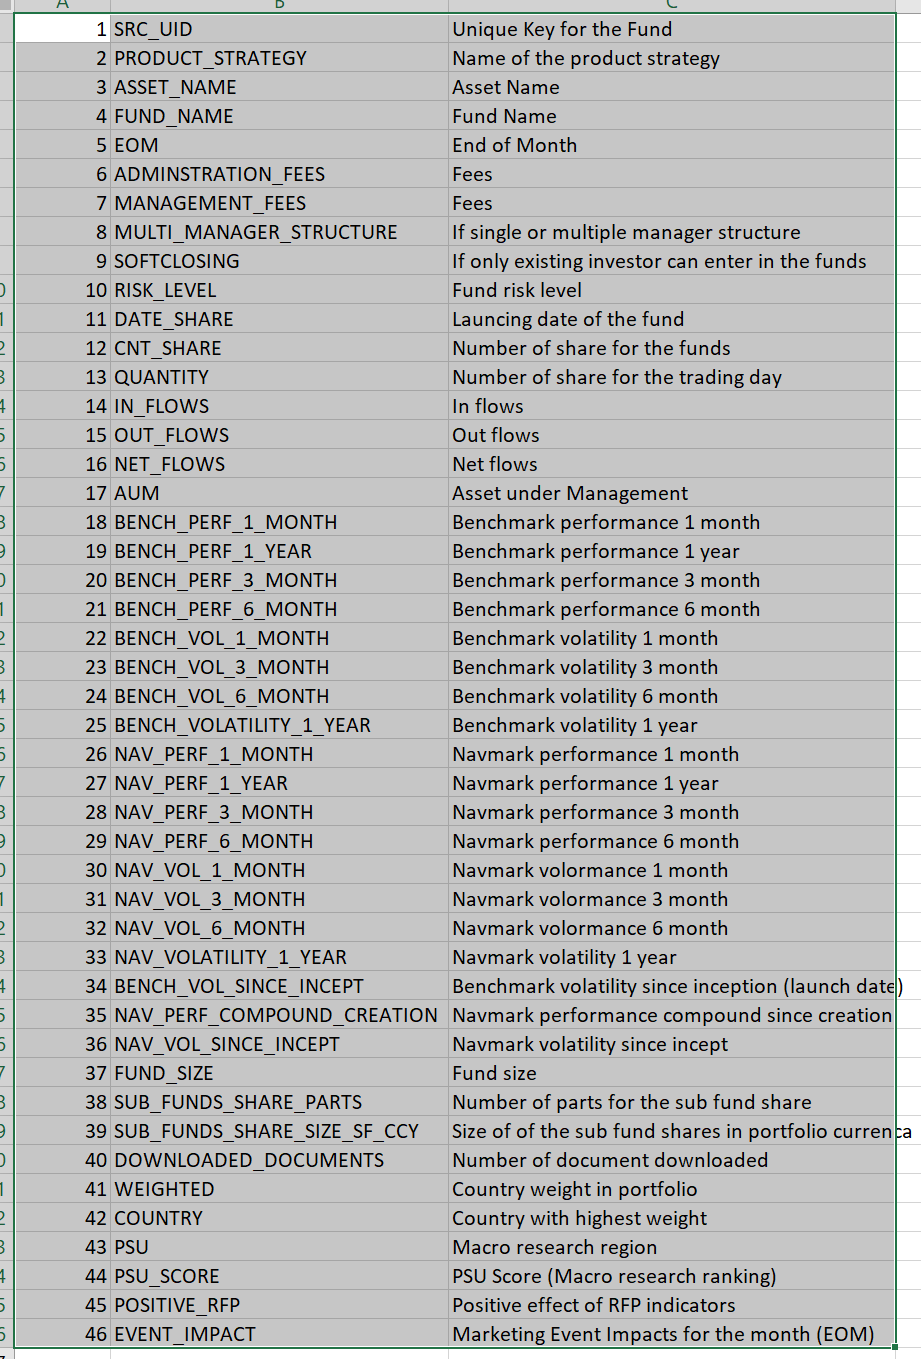

In [4]:
unik_src_uid = np.unique(ts.SRC_UID)
#unik_src_uid

# Missing values
The time series files contains a lot of missing values. The next steps will deal with missing by replacing them with the most relevant information. To do that, I will use:
- existing series
- data from the same fund or product strategy
- mean or median value from the same scope

### Group of missing values
- Data related to NAV, BENCH & FUND SIZE will be completed with linear data between 2 points.
- Downloaded document, I will look in same product strategy and same period.
- Columns related to PSU (macro research scoring) will be completed with same product strategy and same period.
- Event Impact will be replaced by 0 (no event so no impact).
- Null value for RFP (positive RFP) will be set to False as it is a True/False indicators, replaced later by 1 & 0.

In [5]:
# get the missing value count
logging.info('Mising value to deal with')
logging.info(ts.isnull().sum())
ts.isnull().sum()

SRC_UID                           0
PRODUCT_STRATEGY                  0
ASSET_NAME                        0
FUND_NAME                         0
STRATEGY_CAPABILITY               0
IS_STRATEGIC                      0
EOM                               0
ADMINSTRATION_FEES                0
MANAGEMENT_FEES                   0
MULTI_MANAGER_STRUCTURE           0
EXPERIENCE                     1606
SOFTCLOSING                      40
RISK_LEVEL                        0
DATE_SHARE                        0
CNT_SHARE                         0
QUANTITY                          0
IN_FLOWS                          0
OUT_FLOWS                         0
NET_FLOWS                         0
AUM                               0
BENCH_PERF_1_MONTH              421
BENCH_PERF_1_YEAR               691
BENCH_PERF_3_MONTH              469
BENCH_PERF_6_MONTH              541
BENCH_VOL_1_MONTH              2854
BENCH_VOL_3_MONTH               531
BENCH_VOL_6_MONTH               531
BENCH_VOLATILITY_1_YEAR     

#### EVENT IMPACT
The <b>Event Impact</b> has been calculated in the previous Notebook by computing a ratio between number of invited people for a period, number of people who accepted and the total number of people who effectively attended. This gives a score for the period.

Period with <b>NaN</b> value means it was no entry in the dataase (no events) for this month. So let's replace these values with a 0 which means no events.

Later in the analysis, the EVENT IMPACT will be propagated to following month to reflect the effect the score for months follwon an event.

In [6]:
ts_event = ts.loc[:,['SRC_UID','EOM','PRODUCT_STRATEGY','FUND_NAME','EVENT_IMPACT']]
ts_event

,SRC_UID,EOM,PRODUCT_STRATEGY,FUND_NAME,EVENT_IMPACT
0,206670688,2010-01-31,Cyrtodactylus louisiadensis,Oreamnos americanus,NaN
1,206670688,2010-02-28,Cyrtodactylus louisiadensis,Oreamnos americanus,NaN
2,206670688,2010-03-31,Cyrtodactylus louisiadensis,Oreamnos americanus,NaN
3,206670688,2010-04-30,Cyrtodactylus louisiadensis,Oreamnos americanus,1.000000
4,206670688,2010-05-31,Cyrtodactylus louisiadensis,Oreamnos americanus,NaN
...,...,...,...,...,...
9886,213479867994200,2020-09-30,Ara chloroptera,Paradoxurus hermaphroditus,8.783467
9887,213479867994200,2020-10-31,Ara chloroptera,Paradoxurus hermaphroditus,3.779576
9888,213479867994200,2020-11-30,Herpestes javanicus,Paradoxurus hermaphroditus,5.107324
9889,213479867994200,2020-12-31,Herpestes javanicus,Paradoxurus hermaphroditus,5.554061


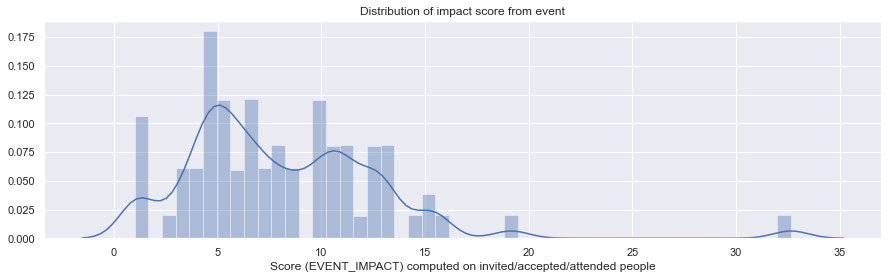

In [7]:
# create a filter to avoid NaN value
f = ts_event['EVENT_IMPACT'].isnull()
sns.set(rc={'figure.figsize':(15,4)})
ax = sns.distplot(ts_event[~f].EVENT_IMPACT.values)
plt.title('Distribution of impact score from event')
plt.xlabel('Score (EVENT_IMPACT) computed on invited/accepted/attended people')
plt.show();

In [8]:
# replace null value with 0
ts['EVENT_IMPACT'].fillna(0, inplace=True)
ts.isnull().sum()

SRC_UID                           0
PRODUCT_STRATEGY                  0
ASSET_NAME                        0
FUND_NAME                         0
STRATEGY_CAPABILITY               0
IS_STRATEGIC                      0
EOM                               0
ADMINSTRATION_FEES                0
MANAGEMENT_FEES                   0
MULTI_MANAGER_STRUCTURE           0
EXPERIENCE                     1606
SOFTCLOSING                      40
RISK_LEVEL                        0
DATE_SHARE                        0
CNT_SHARE                         0
QUANTITY                          0
IN_FLOWS                          0
OUT_FLOWS                         0
NET_FLOWS                         0
AUM                               0
BENCH_PERF_1_MONTH              421
BENCH_PERF_1_YEAR               691
BENCH_PERF_3_MONTH              469
BENCH_PERF_6_MONTH              541
BENCH_VOL_1_MONTH              2854
BENCH_VOL_3_MONTH               531
BENCH_VOL_6_MONTH               531
BENCH_VOLATILITY_1_YEAR     

### POSITIVE RFP


In [9]:
ts_rfp = ts.loc[:,['SRC_UID','EOM','PRODUCT_STRATEGY','FUND_NAME','POSITIVE_RFP']]
f = ts_rfp['POSITIVE_RFP'].isnull()
ts_rfp[~f].head(6)

,SRC_UID,EOM,PRODUCT_STRATEGY,FUND_NAME,POSITIVE_RFP
173,206670690,2013-05-31,Ara chloroptera,Melursus ursinus,True
182,206670690,2014-02-28,Cyrtodactylus louisiadensis,Melursus ursinus,True
183,206670690,2014-03-31,Ara chloroptera,Melursus ursinus,True
186,206670690,2014-06-30,Ara chloroptera,Melursus ursinus,True
187,206670690,2014-07-31,Cyrtodactylus louisiadensis,Melursus ursinus,True
188,206670690,2014-08-31,Ara chloroptera,Melursus ursinus,True


In [10]:
ts['POSITIVE_RFP'].fillna(False,inplace=True)
ts.isnull().sum()

SRC_UID                           0
PRODUCT_STRATEGY                  0
ASSET_NAME                        0
FUND_NAME                         0
STRATEGY_CAPABILITY               0
IS_STRATEGIC                      0
EOM                               0
ADMINSTRATION_FEES                0
MANAGEMENT_FEES                   0
MULTI_MANAGER_STRUCTURE           0
EXPERIENCE                     1606
SOFTCLOSING                      40
RISK_LEVEL                        0
DATE_SHARE                        0
CNT_SHARE                         0
QUANTITY                          0
IN_FLOWS                          0
OUT_FLOWS                         0
NET_FLOWS                         0
AUM                               0
BENCH_PERF_1_MONTH              421
BENCH_PERF_1_YEAR               691
BENCH_PERF_3_MONTH              469
BENCH_PERF_6_MONTH              541
BENCH_VOL_1_MONTH              2854
BENCH_VOL_3_MONTH               531
BENCH_VOL_6_MONTH               531
BENCH_VOLATILITY_1_YEAR     

## NAV, BENCH performances et volatility, Number of Documents downloaded
I will fill the gap by a linear value between 2 points. If the start or the end of the serie is missing I will fill the gap by the most recent value. The function will compute missing data at the fund name level.

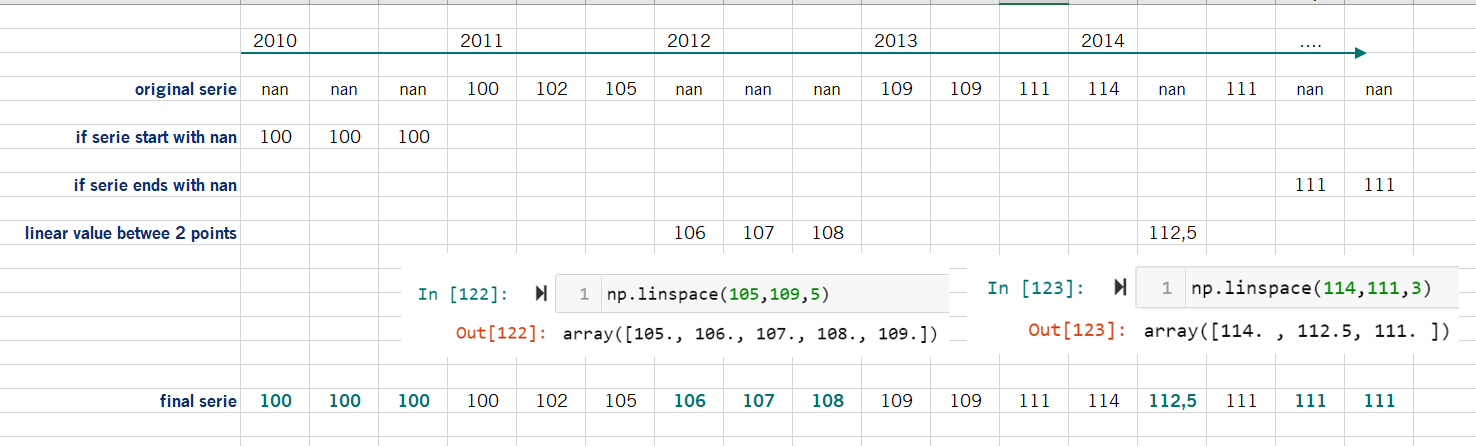


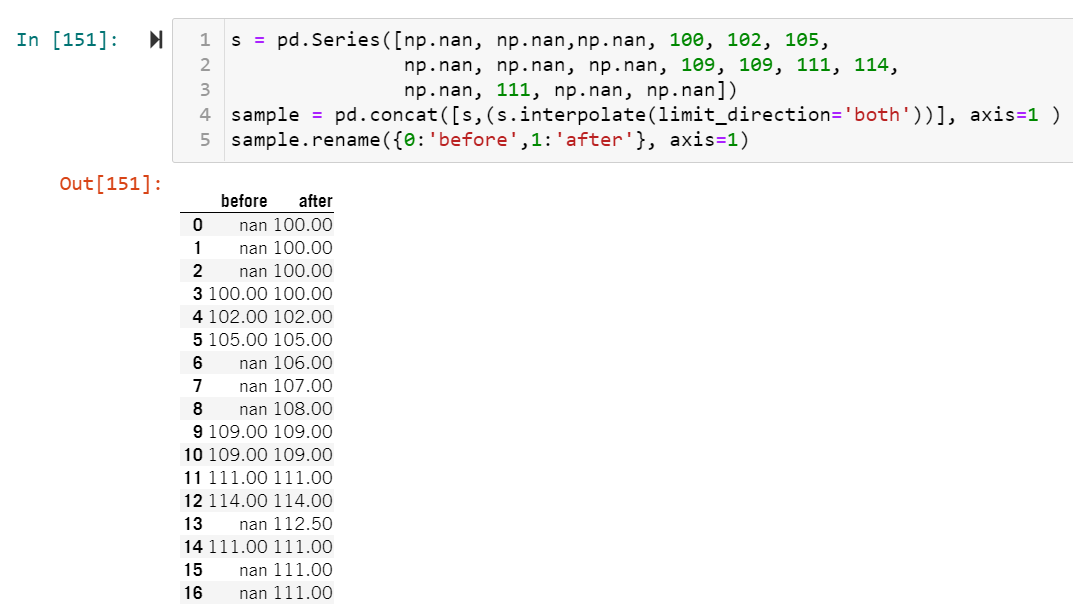

In [11]:
# start by bench columns
bench_cols = [x for x in ts.columns.tolist() if 'BENCH' in x]
logging.info('Columns with BENCHMARK')
logging.info(bench_cols)
# append the SRC UID (key funds) and the EOM
bench_cols.append('SRC_UID')
bench_cols.append('EOM')
ts_bench = ts[bench_cols]
ts_bench = ts_bench.set_index(['SRC_UID','EOM'])
ts_bench.sample(6)

,,BENCH_PERF_1_MONTH,BENCH_PERF_1_YEAR,BENCH_PERF_3_MONTH,BENCH_PERF_6_MONTH,BENCH_VOL_1_MONTH,BENCH_VOL_3_MONTH,BENCH_VOL_6_MONTH,BENCH_VOLATILITY_1_YEAR,BENCH_VOL_SINCE_INCEPT
SRC_UID,EOM,,,,,,,,,
206670742,2015-03-31,0.002688,0.157762,0.064628,0.092884,0.114868,0.097584,0.146513,0.072491,0.144403
206670688,2013-07-31,0.000138,0.002174,0.000494,0.001038,0.000058,0.000046,0.000047,0.000150,0.005910
168413682951,2010-04-30,-0.006617,0.044030,0.011834,0.014461,NaN,0.027554,0.024685,0.031997,0.037013
206670694,2015-11-30,0.012215,0.032303,0.055869,-0.050354,0.096140,0.162362,0.238265,0.146000,0.162438
40234001221,2011-10-31,0.018762,-0.040053,0.025186,-0.029596,0.067458,0.178738,0.148424,0.051595,0.064589
192291882972375,2021-01-31,-0.000481,0.044828,0.036894,0.043071,0.019587,0.024399,0.032629,0.116220,0.070038


In [12]:
# I take 1 fund and llok missing value before and after applying interpolate()
ts_206670686 = ts_bench.loc[206670688,:]
ts_206670686.isnull().sum()
ts_206670686.sample(6)

,BENCH_PERF_1_MONTH,BENCH_PERF_1_YEAR,BENCH_PERF_3_MONTH,BENCH_PERF_6_MONTH,BENCH_VOL_1_MONTH,BENCH_VOL_3_MONTH,BENCH_VOL_6_MONTH,BENCH_VOLATILITY_1_YEAR,BENCH_VOL_SINCE_INCEPT
EOM,,,,,,,,,
2016-10-31,0.000465,0.005759,0.001321,0.002861,0.000238,0.000078,0.000149,0.000542,0.005801
2014-04-30,0.000075,0.001450,0.000264,0.000605,NaN,0.000018,0.000041,0.000125,0.005932
2012-10-31,0.000129,0.002741,0.000606,0.001285,0.000062,0.000119,0.000105,0.000229,0.005873
2017-12-31,0.001137,0.010698,0.003208,0.006287,NaN,0.000192,0.000156,0.000308,0.005655
2013-10-31,0.000103,0.001917,0.000349,0.000844,0.000043,0.000017,0.000050,0.000119,0.005919
2018-11-30,0.001813,0.019043,0.005434,0.010671,NaN,0.000333,0.000264,0.000849,0.004479


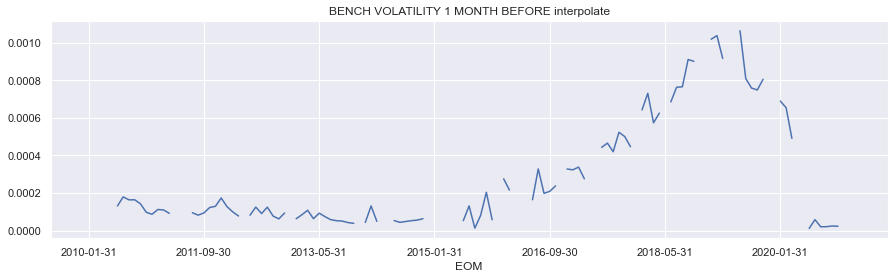

In [13]:
# plot line with Nan value
ts_206670686['BENCH_VOL_1_MONTH'].plot()
plt.title('BENCH VOLATILITY 1 MONTH BEFORE interpolate')
plt.show();

In [14]:
# apply interpolate() to the columns with most missing value
# ts_206670686['BENCH_VOL_1_MONTH'].interpolate(limit_direction='both')

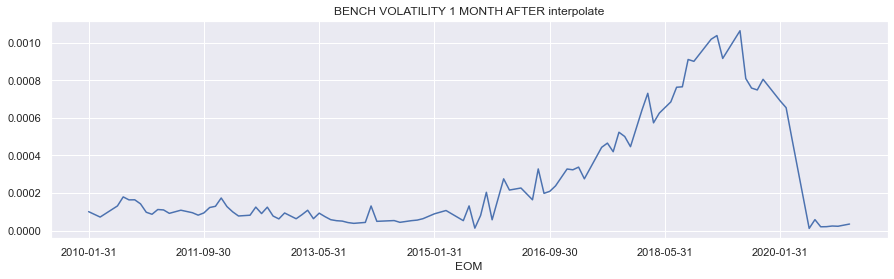

In [15]:
# plot the same series by applying the interpolate()
ts_206670686['BENCH_VOL_1_MONTH'].interpolate(limit_direction='both').plot()
plt.title('BENCH VOLATILITY 1 MONTH AFTER interpolate')
plt.show();

<b>It's look like the _interpolate()_ method of the DataFrame operates well to fill missing values as I expected.<b> I will apply this method to all "BENCHMARK" columns of my <b>ts</b> dataset.</b>.
    
I must loop over all funds (SRC_UID) and for each funds (series) apply and interpolate() method on columns to fill Nan values.

In [16]:
try:
    ts.set_index(['SRC_UID','EOM'], inplace=True)
except:
    logging.warning('ts dataset has already SRC_UID and EOM as index column')
ts.sample(6)

,,PRODUCT_STRATEGY,ASSET_NAME,FUND_NAME,STRATEGY_CAPABILITY,IS_STRATEGIC,ADMINSTRATION_FEES,MANAGEMENT_FEES,MULTI_MANAGER_STRUCTURE,EXPERIENCE,SOFTCLOSING,...,FUND_SIZE,SUB_FUNDS_SHARE_PARTS,SUB_FUNDS_SHARE_SIZE_SF_CCY,DOWNLOADED_DOCUMENTS,WEIGHTED,COUNTRY,PSU,PSU_SCORE,POSITIVE_RFP,EVENT_IMPACT
SRC_UID,EOM,,,,,,,,,,,,,,,,,,,,,
40234253942,2015-03-31,Ara chloroptera,Arctogalidia trivirgata,Cordylus giganteus,Multi Asset,Yes,0.000300,0.007167,0,2754.055271,0.0,...,5.275969e+08,1.061053e+05,1.318992e+08,1631.0,NaN,NaN,NaN,NaN,True,6.401102
437983596250,2018-01-31,Panthera pardus,Ceratotherium simum,Macaca fuscata,Core & Specialist Equities,No,0.000700,0.008250,0,NaN,1.0,...,3.839826e+08,5.795612e+05,9.599565e+07,NaN,NaN,NaN,NaN,NaN,False,11.186124
880923451687,2010-11-30,Cyrtodactylus louisiadensis,unavailable,Cabassous sp.,Money Market,No,0.000278,0.000433,1,3384.255271,0.0,...,1.091073e+09,1.770631e+06,NaN,NaN,NaN,NaN,NaN,NaN,False,0.000000
1134069654772,2016-11-30,Ara chloroptera,Centrocercus urophasianus,Hystrix cristata,Thematic,Yes,0.002605,0.013750,1,355.425527,0.0,...,4.272742e+09,1.137904e+06,2.373746e+08,9489.0,0.5446,U.S.A.,US,NaN,True,12.535852
1676124906944,2017-03-31,Ara chloroptera,Varanus sp.,Madoqua kirkii,Alternatives,No,0.000229,0.002229,0,637.451054,0.0,...,6.405089e+08,4.776017e+05,5.822809e+07,180.0,NaN,NaN,NaN,NaN,False,12.625619
108193333943,2010-02-28,Cyrtodactylus louisiadensis,Ara ararauna,Crotalus cerastes,Money Market,No,0.000300,0.000980,0,NaN,0.0,...,1.705172e+08,5.653128e+04,NaN,NaN,NaN,NaN,NaN,NaN,False,0.000000


##### I will loop in the unik_src_uid, for each value I will apply interpolate(limit_direction='both') for each columns BENCH_xxxx and NAV_xxx and FUND_SIZE_xxx

In [17]:
# define NAV columns
nav_cols = [x for x in ts.columns.tolist() if 'NAV' in x]

# define BENCH columns
bench_cols = [x for x in ts.columns.tolist() if 'BENCH' in x]

# define SUB_FUNDS_SHARE columns
sfs_cols = [x for x in ts.columns.tolist() if 'SUB_FUNDS_SHARE' in x]



# concatenate the 3 list
interpolate_columns = nav_cols + bench_cols + sfs_cols 

for fund in unik_src_uid:
    for col in interpolate_columns:
        ts.loc[fund,col] = ts.loc[fund,col].interpolate(limit_direction='both').values
        
        
ts.isnull().sum()
    

PRODUCT_STRATEGY                  0
ASSET_NAME                        0
FUND_NAME                         0
STRATEGY_CAPABILITY               0
IS_STRATEGIC                      0
ADMINSTRATION_FEES                0
MANAGEMENT_FEES                   0
MULTI_MANAGER_STRUCTURE           0
EXPERIENCE                     1606
SOFTCLOSING                      40
RISK_LEVEL                        0
DATE_SHARE                        0
CNT_SHARE                         0
QUANTITY                          0
IN_FLOWS                          0
OUT_FLOWS                         0
NET_FLOWS                         0
AUM                               0
BENCH_PERF_1_MONTH              255
BENCH_PERF_1_YEAR               255
BENCH_PERF_3_MONTH              255
BENCH_PERF_6_MONTH              255
BENCH_VOL_1_MONTH               255
BENCH_VOL_3_MONTH               255
BENCH_VOL_6_MONTH               255
BENCH_VOLATILITY_1_YEAR         255
NAV_PERF_1_MONTH                  0
NAV_PERF_1_YEAR             

In [18]:
f = ts['BENCH_PERF_3_MONTH'].isnull()
np.unique(ts[f].reset_index()['SRC_UID'])

array([ 737766433094, 1676124906944], dtype=int64)

I have 2 funds with no benchmark performance. It's normal because not all funds (most of) have an official benchmark. <b>So I decide to keep those funds and set the benchmark performance to 0</b>

## Number of document downloaded.
A lot of data are missing at the begining of 2010.
To fill the gap, I will set when data of the 2010-01-31 a value to 1 and then compute a linera (interpolate) until the 1st value extracted from the system. 

In [19]:
col = 'DOWNLOADED_DOCUMENTS'
for fund in unik_src_uid:
    first_date = ts.loc[fund,'DOWNLOADED_DOCUMENTS'].index[0]

    if np.isnan(ts.loc[(fund,first_date),'DOWNLOADED_DOCUMENTS']):
        # logging.info(ts.loc[(fund,first_date),'DOWNLOADED_DOCUMENTS'])
        ts.loc[(fund,first_date),'DOWNLOADED_DOCUMENTS']=1
    # apply interpolate
    ts.loc[fund,col] = ts.loc[fund,col].interpolate(limit_direction='both').values
        

<AxesSubplot:xlabel='EOM'>

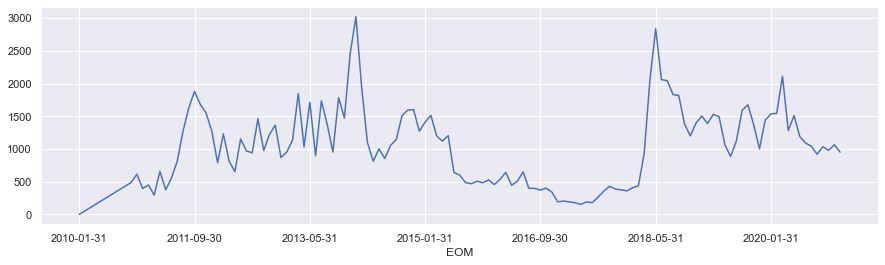

In [20]:
ts.loc[(1676124906944),'DOWNLOADED_DOCUMENTS'].plot()

### PSU and remaining columsn will be set to 0

- PSU are considerate as neutral (0)
- benchmark and nav perf compoud perf will be set to 0

In [21]:
ts = ts.fillna(0)
ts.isnull().sum()

PRODUCT_STRATEGY               0
ASSET_NAME                     0
FUND_NAME                      0
STRATEGY_CAPABILITY            0
IS_STRATEGIC                   0
ADMINSTRATION_FEES             0
MANAGEMENT_FEES                0
MULTI_MANAGER_STRUCTURE        0
EXPERIENCE                     0
SOFTCLOSING                    0
RISK_LEVEL                     0
DATE_SHARE                     0
CNT_SHARE                      0
QUANTITY                       0
IN_FLOWS                       0
OUT_FLOWS                      0
NET_FLOWS                      0
AUM                            0
BENCH_PERF_1_MONTH             0
BENCH_PERF_1_YEAR              0
BENCH_PERF_3_MONTH             0
BENCH_PERF_6_MONTH             0
BENCH_VOL_1_MONTH              0
BENCH_VOL_3_MONTH              0
BENCH_VOL_6_MONTH              0
BENCH_VOLATILITY_1_YEAR        0
NAV_PERF_1_MONTH               0
NAV_PERF_1_YEAR                0
NAV_PERF_3_MONTH               0
NAV_PERF_6_MONTH               0
NAV_VOL_1_

In [22]:
ts.to_csv(folder+'cleaned_time_series.csv')

logging.info('ts dataset save in csv file with {} rows and {} columns'.format(ts.shape[0],ts.shape[1]))

## Check net flows consistency

The Net flows per observation must be the in flows - out flows. I discovered some strange values. So I decided to compute the NET FLOWS which will be used to create the TARGET value by additioning the IN FLOWS and OUT FLOWS.

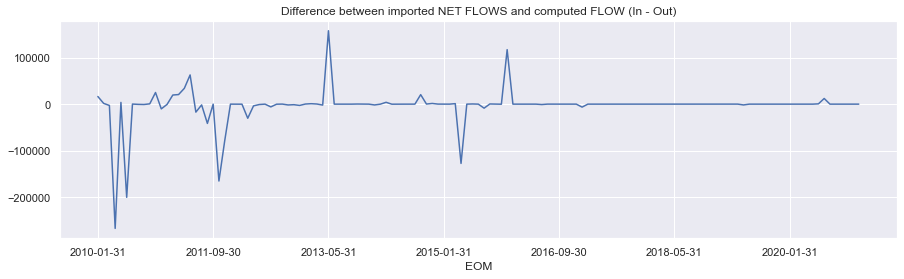

In [23]:
# compute the net flows from IN FLOWN and OUT FLOWS and plot them compared to NET FLOWS imported
flows_cols = ['IN_FLOWS','OUT_FLOWS','NET_FLOWS','COMPUTED_FLOWS','CHECKED','DIFF_FLOWS']
ts['COMPUTED_FLOWS']=ts['IN_FLOWS']+ts['OUT_FLOWS']
ts['CHECKED']=ts['COMPUTED_FLOWS']==ts['NET_FLOWS']
ts['DIFF_FLOWS']=ts['COMPUTED_FLOWS']-ts['NET_FLOWS']
temp=ts.loc[:,['NET_FLOWS','COMPUTED_FLOWS','DIFF_FLOWS']].reset_index()
temp.drop('SRC_UID', axis=1, inplace=True)
temp=temp.groupby('EOM').sum()
temp['DIFF_FLOWS'].plot()
plt.title('Difference between imported NET FLOWS and computed FLOW (In - Out)')
plt.show();

I have some important difference in the begining of the period of obser vation in 2010 and agin in 2001, 2013, 2015. The fact is that some flows are not in the system such as switch or seed money. I decided to adapt my NET FLOWS to the computation of IN-FLOWS minus OUT-FLOWS.

In [24]:
ts['NET_FLOWS']=ts['IN_FLOWS']+ts['OUT_FLOWS']

# Target value for modeling

The problem will be a classification modeling issue. The target will be computed on the net flows for each observation. I decided to calculate the importance of the net flow to allocate:

 - (-1) if the outflow is important and can have an impact
 - (0) if the net flow is in a range of value (negtive, positive or 0) and will have no impact
 - (+1) if the positive flow might have an impact
 
 To compute the target I will use the AUM and compare with the flow.
 
 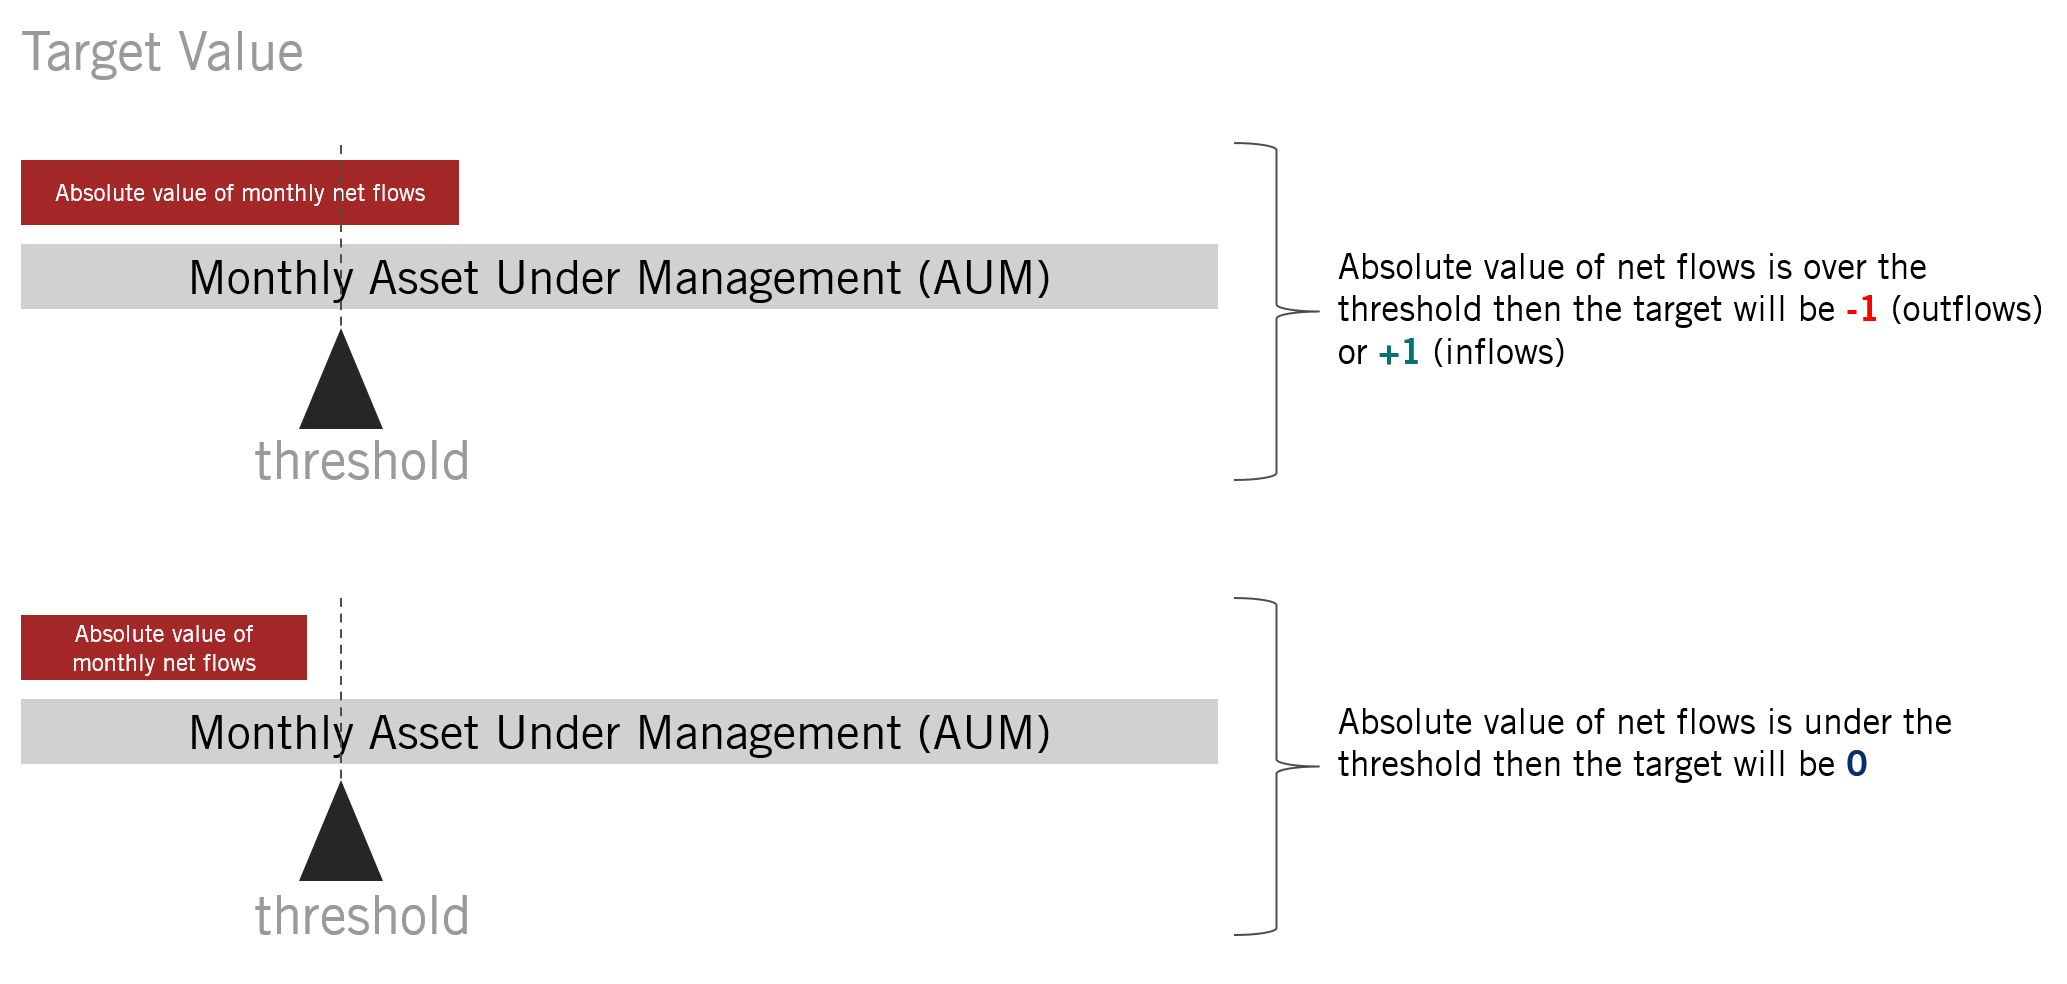
 
 ## Explore the method with .qcut()
 By using the <i>qcut()</i> method of DataFrame I will create the <b>target</b> value. The method will cut in 3 bins [-1, 0, +1] the atio of net flows related to AUM.

In [25]:
# create filter to avoid computing for net flows = 0 or when (if existing) AUM = 0
f1 = ts['NET_FLOWS'] != 0
f2 = ts['AUM'] != 0

# create a temp ts
ts_temp = ts.loc[(f1 & f2),['NET_FLOWS','AUM']].copy()
ts_temp.sample(6)

,,NET_FLOWS,AUM
SRC_UID,EOM,,
55902523917,2019-03-31,-8294418,889406652
206670727,2012-05-31,-8185675,211097978
186711785308213,2014-01-31,103398007,1567126865
52079200642,2012-07-31,9471851,375692858
40234253942,2014-08-31,4470885,457858138
52079200642,2014-01-31,-30309615,373709676


In [26]:
# compute the THRESHOLD
ts_temp['THRESHOLD'] = ts_temp['NET_FLOWS'] / ts_temp['AUM']
ts_temp.sample(6)

,,NET_FLOWS,AUM,THRESHOLD
SRC_UID,EOM,,,
188703129863464,2013-08-31,-11912,6377237,-0.001868
1134069654772,2012-05-31,-20036339,778978783,-0.025721
207934051132,2013-04-30,4591083,303964944,0.015104
1489764652,2015-06-30,64394710,1432739103,0.044945
206670770,2014-07-31,-10956494,198624378,-0.055162
206670723,2017-04-30,70680480,4902687913,0.014417


In [27]:
# assign 1 fund to check assumption
fund_src_uid = 213479867994200

In [28]:
ts_temp.loc[fund_src_uid,'THRESHOLD'].describe()

count    40.000000
mean      0.097721
std       0.223126
min      -0.035066
25%       0.009284
50%       0.027170
75%       0.059193
max       1.000000
Name: THRESHOLD, dtype: float64

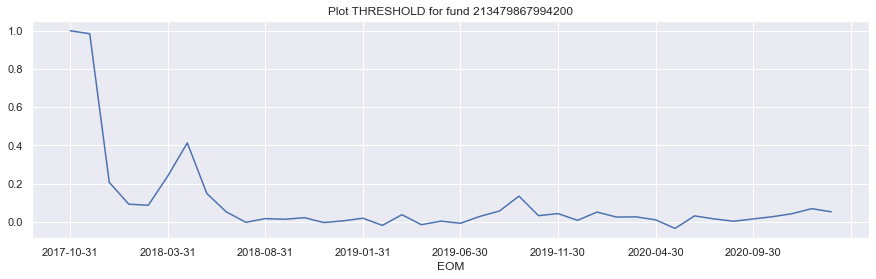

In [29]:
# get the THRESHOLD serie
s=ts_temp.loc[fund_src_uid,'THRESHOLD'].values

edge=[-1,-0.01,0.01,1]
# create a 2nd serie by allocating -1, 0 or +1 depending of value of THRESHOLD
# by using qcut I am sure I will have a balanced distribution
c=pd.cut(s,edge, labels=[-1,0,1])
c = c.tolist()
ts_temp.loc[fund_src_uid,'TARGET']=c

# plot

ts_temp.loc[fund_src_uid,'THRESHOLD'].plot()
plt.title('Plot THRESHOLD for fund {}'.format(fund_src_uid))
plt.show();

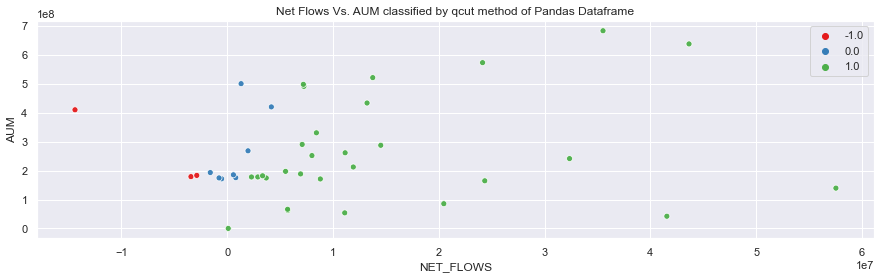

In [30]:
# plot data for this fund in a scatter
# X-axis is the net flows and Y-axis is the AUM
# low net flows or negative is tagged as -1
# high net flows are tagged as +1
# other flows are neutral and tagged as 0
ts_temp.loc[:,'TARGET'] = ts_temp.TARGET.astype(np.float)
sns.scatterplot(data=ts_temp.loc[fund_src_uid,:], x='NET_FLOWS', y='AUM', hue=ts_temp.loc[fund_src_uid,'TARGET'].values, alpha = 0.95,
                palette=sns.color_palette("Set1", ts_temp.loc[fund_src_uid,'TARGET'].nunique()))
plt.title('Net Flows Vs. AUM classified by qcut method of Pandas Dataframe')
plt.show();

In [31]:
ts

PRODUCT_STRATEGY           ASSET_NAME  \
SRC_UID         EOM                                                            
206670688       2010-01-31  Cyrtodactylus louisiadensis       Dusicyon thous   
                2010-02-28  Cyrtodactylus louisiadensis       Dusicyon thous   
                2010-03-31  Cyrtodactylus louisiadensis       Dusicyon thous   
                2010-04-30  Cyrtodactylus louisiadensis       Dusicyon thous   
                2010-05-31  Cyrtodactylus louisiadensis       Dusicyon thous   
...                                                 ...                  ...   
213479867994200 2020-09-30              Ara chloroptera  Phasianus colchicus   
                2020-10-31              Ara chloroptera  Phasianus colchicus   
                2020-11-30          Herpestes javanicus  Phasianus colchicus   
                2020-12-31          Herpestes javanicus  Phasianus colchicus   
                2021-01-31          Herpestes javanicus  Phasianus colchicus   

                                             FUND_NAME STRATEGY_CAPABILITY  \
SRC_UID         EOM                                                          
206670688       2010-01-31         Oreamnos americanus        Money Market   
                2010-02-28         Oreamnos americanus        Money Market   
                2010-03-31         Oreamnos americanus        Money Market   
                2010-04-30         Oreamnos americanus        Money Market   
                2010-05-31         Oreamnos americanus        Money Market   
...                                                ...                 ...   
213479867994200 2020-09-30  Paradoxurus hermaphroditus         Multi Asset   
                2020-10-31  Paradoxurus hermaphroditus         Multi Asset   
                2020-11-30  Paradoxurus hermaphroditus         Multi Asset   
                2020-12-31  Paradoxurus hermaphroditus         Multi Asset   
                2021-01-31  Paradoxurus hermaphroditus         Multi Asset   

                           IS_STRATEGIC  ADMINSTRATION_FEES  MANAGEMENT_FEES  \
SRC_UID         EOM                                                            
206670688       2010-01-31           No            0.000277         0.001631   
                2010-02-28           No            0.000277         0.001631   
                2010-03-31           No            0.000277         0.001631   
                2010-04-30           No            0.000277         0.001631   
                2010-05-31           No            0.000277         0.001631   
...                                 ...                 ...              ...   
213479867994200 2020-09-30          Yes            0.000300         0.005000   
                2020-10-31          Yes            0.000300         0.005000   
                2020-11-30          Yes            0.000300         0.005000   
                2020-12-31          Yes            0.000300         0.005000   
                2021-01-31          Yes            0.000300         0.005000   

                            MULTI_MANAGER_STRUCTURE  EXPERIENCE  SOFTCLOSING  \
SRC_UID         EOM                                                            
206670688       2010-01-31                        1         0.0          0.0   
                2010-02-28                        1         0.0          0.0   
                2010-03-31                        1         0.0          0.0   
                2010-04-30                        1         0.0          0.0   
                2010-05-31                        1         0.0          0.0   
...                                             ...         ...          ...   
213479867994200 2020-09-30                        0         0.0          0.0   
                2020-10-31                        0         0.0          0.0   
                2020-11-30                        0         0.0          0.0   
                2020-12-31                        0         0.

##### This method gives good result so I will create my TARGET value using the qcut method by fund (SRC_UID)

In [32]:
# loop in the unik_src_uid (list of funds keys)
# for each key compute the target series
# assigne the series to the TARGET columns for the fund
ts['THRESHOLD'] = ts_temp['NET_FLOWS'] / ts_temp['AUM']
edge=[-1,-0.012,0.012,1]
for fund_src_uid in unik_src_uid:
    # get the THRESHOLD serie
    s=ts.loc[fund_src_uid,'THRESHOLD'].values

    # create a 2nd serie by allocating -1, 0 or +1 depending of value of THRESHOLD
    # by using qcut I am sure I will have a balanced distribution
    c=pd.cut(s,edge, labels=[-1,0,1])
    cv=c.tolist()
    ts.loc[fund_src_uid,'TARGET']=cv

ts.fillna(0, inplace=True)
print(ts.loc[:,['TARGET','FUND_NAME']].groupby('TARGET').count())

        FUND_NAME
TARGET           
-1.0         3309
 0.0         3265
 1.0         3317


In [33]:
ts.to_csv(folder+'cleaned_time_series.csv')
logging.info(ts.loc[:,['TARGET','FUND_NAME']].groupby('TARGET').count())
logging.info('ts dataset save in csv file with {} rows and {} columns'.format(ts.shape[0],ts.shape[1]))

In [34]:
print('************* END OF NOTEBOOK 04-EDA-TimeSeris_a')

************* END OF NOTEBOOK 04-EDA-TimeSeris_a
